In [1]:
!pip install wandb

In [2]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import wandb

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
wandb.init(project="Credit Card Fraud", entity="kreeeeesha")  # Replace with your project and username

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: krishachemburkar (kreeeeesha). Use `wandb login --relogin` to force relogin


In [52]:
data = pd.read_csv('/content/creditcard.csv')

In [53]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
data_transformed = data.copy()

In [9]:
scaler = StandardScaler()
data_transformed.iloc[:, :-1] = scaler.fit_transform(data_transformed.iloc[:, :-1])


In [10]:
normal_data = data_transformed[data_transformed['Class'] == 0].drop(['Time','Class'], axis=1)  # Drop label column for training
anomalous_data = data_transformed[data_transformed['Class'] == 1].drop(['Time','Class'], axis=1)  # Drop label column for testing

# Train-test split for normal data (only for training)
X_train, X_test = train_test_split(normal_data, test_size=0.1, random_state=42)

# For testing, keep both normal and anomalous data
X_test = pd.concat([X_test, anomalous_data])

# You can also create labels for the test set (0 = normal, 1 = anomaly)
y_test = pd.concat([pd.Series([0] * len(X_test), name='Class'),
                    pd.Series([1] * len(anomalous_data), name='Class')])

In [12]:
X_test.shape

(28924, 29)

In [13]:
X_train.shape

(255883, 29)

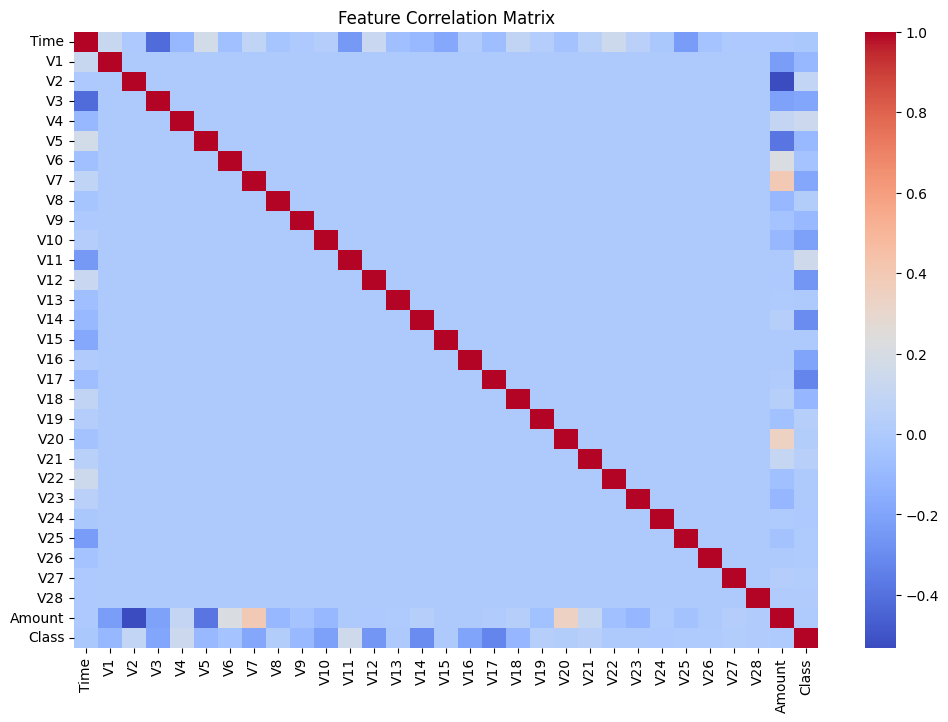

In [14]:
# Calculate the correlation matrix
corr_matrix = data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Feature Correlation Matrix')
plt.show()


In [19]:
X_train_tensor = torch.tensor(X_train.values, dtype = torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype = torch.float32)

In [20]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, code_size):
        super().__init__()
        self.enc_container = nn.Sequential(
                                nn.Linear(input_size, 20),
                                nn.LeakyReLU(),
                                nn.Linear(20, 32),
                                nn.LeakyReLU(),
                                nn.Linear(32, 16),
                                nn.LeakyReLU(),
                                nn.Linear(16, code_size))
        self.dec_container = nn.Sequential(
                                nn.Linear(code_size, 16),
                                nn.LeakyReLU(),
                                nn.Linear(16, 32),
                                nn.LeakyReLU(),
                                nn.Linear(32, 20),
                                nn.LeakyReLU(),
                                nn.Linear(20, input_size))
    def forward(self,x):
        x = self.enc_container(x)
        x = self.dec_container(x)
        return x

In [21]:
X_train.shape

(255883, 29)

In [22]:
input_size = X_train.shape[1]

In [23]:
code_size = 8
learning_rate = 5e-5
batch_size = 32
num_epochs = 100

In [24]:
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [25]:
# data

This is used to make our dataset suitable for training. The TensorDataset is used to make the (input,output) combinations and the DataLoader is used to send the data in batches for efficient and fast training.

In [26]:
model = Autoencoder(input_size, code_size)

In [27]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [28]:
wandb.log({"learning_rate": learning_rate})

In [29]:
losses = []
for epoch in range(num_epochs):
    for train_data in train_loader:
        inputs, _ = train_data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
    losses.append(loss)
    print(f'Epoch {epoch+1}: {loss}')
    wandb.log({"train_loss": loss})

Epoch 1: 0.6886602640151978
Epoch 2: 0.6268105506896973
Epoch 3: 0.4022431969642639
Epoch 4: 0.39698874950408936
Epoch 5: 0.5582209825515747
Epoch 6: 0.36405235528945923
Epoch 7: 0.5221631526947021
Epoch 8: 0.5558989644050598
Epoch 9: 0.5161242485046387
Epoch 10: 0.4282233715057373
Epoch 11: 0.6757853627204895
Epoch 12: 0.793635368347168
Epoch 13: 0.4163261651992798
Epoch 14: 0.6460270881652832
Epoch 15: 0.3181757926940918
Epoch 16: 0.4393191337585449
Epoch 17: 0.6320169568061829
Epoch 18: 0.9565416574478149
Epoch 19: 0.3499835729598999
Epoch 20: 0.47896870970726013
Epoch 21: 1.1559925079345703
Epoch 22: 0.37248745560646057
Epoch 23: 0.3562227785587311
Epoch 24: 0.44804468750953674
Epoch 25: 0.4192756116390228
Epoch 26: 0.43613871932029724
Epoch 27: 0.37755247950553894
Epoch 28: 0.3331435024738312
Epoch 29: 0.37488874793052673
Epoch 30: 0.5872312188148499
Epoch 31: 0.3585781753063202
Epoch 32: 0.38057956099510193
Epoch 33: 0.4078481197357178
Epoch 34: 0.48117324709892273
Epoch 35: 0.29

In [30]:
losses = [loss.detach().numpy() for loss in losses]

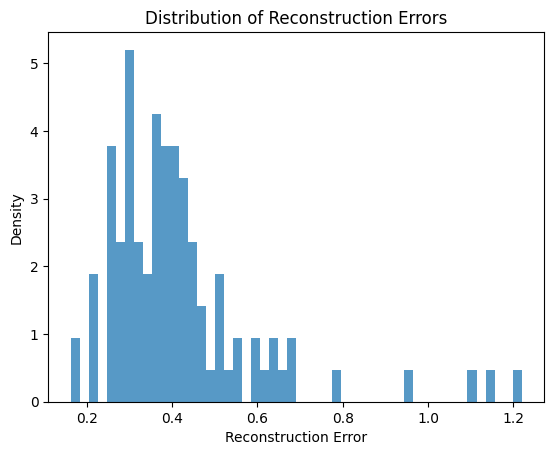

In [33]:
plt.hist(losses, bins=50, density=True, alpha=0.75)
plt.title('Distribution of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')
plt.show()


In [72]:
#Deciding threshold based on percentile of the errors
threshold = np.percentile(losses, 99.999)

In [73]:
threshold

1.219428022340536

In [82]:
threshold = 2

In [83]:
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    print(test_outputs)
    test_loss = criterion(test_outputs, X_test_tensor)
    print(f'Test Loss: {test_loss}')

tensor([[ 0.6791,  0.1260, -0.5098,  ...,  0.0079,  0.2201, -0.2839],
        [-0.7462,  0.4134,  0.7841,  ..., -0.9063, -0.4841, -0.2329],
        [-0.3562, -0.6384,  1.1150,  ..., -0.0019,  0.1025, -0.1611],
        ...,
        [-0.0823,  0.3364, -0.0897,  ...,  0.3593,  0.2924,  0.2231],
        [ 0.1214,  0.3510, -0.3529,  ...,  0.6207,  0.6029,  0.7119],
        [ 0.9388,  0.0281, -1.5592,  ..., -0.1360,  0.0081, -0.2365]])
Test Loss: 0.6801210641860962


In [84]:
anomalies = np.sum(np.square(test_outputs.numpy() - X_test_tensor.numpy()), axis=1)/input_size
predicted_labels = (anomalies > threshold).astype(int)

In [85]:
test_indices = X_test.index

In [86]:
true_labels = data.loc[test_indices, 'Class'].values

### Test Data

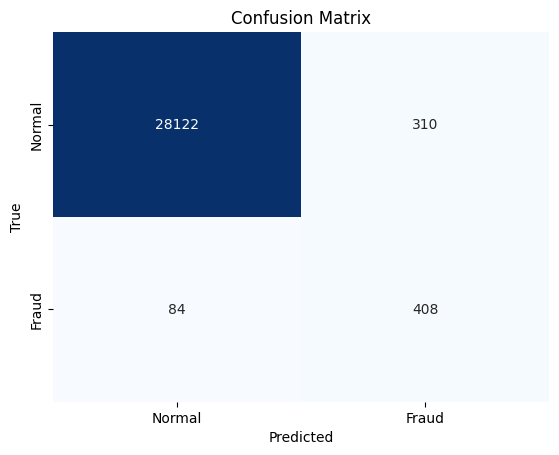

In [87]:
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [88]:
TN, FP = cm[0, 0], cm[0, 1]  # First row: TN and FP
FN, TP = cm[1, 0], cm[1, 1]  # Second row: FN and TP

TN, FP, FN, TP

(28122, 310, 84, 408)

In [89]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

Accuracy: 0.99
Precision: 0.57
Recall: 0.83
F1 Score: 0.67
